# Nearly Constant Acceleration Model
# 3-dimensional CWPA model.
# Based on Bar Shalom, X.Rong Li, Kirubarajan, Estimation with applications to tracking and navigation.2001
# Nonlinear observation scheme.
# Created: 15 June 2016

In [1]:
# Import the required libraries
import numpy as np
import math
from numpy import linalg
import scipy.linalg
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define variables for the simulation
dt = 0.1 ; #[s]
t = np.arange(0,20,dt,dtype=float) # [s]

In [3]:
dimensionality = 3; # 3 dimensional problem
nStates = 3; # 3 states per dimension. position,velocity and acceleration
nVars = nStates*dimensionality; 
x_state = np.zeros([nVars,len(t)],dtype=float);

def fn_Generate_STM_polynom(zeta,nStates):
    # fn_Generate_STM_polynom creates the state transition matrix for polynomial models 
    # of degree (nStates-1) over a span of transition of zeta [s].
    # Polynomial models are a subset of the class of constant-coefficient linear DEs.
    # Refer to: Tracking Filter Engineering, Norman Morrison.
    stm = np.eye(nStates,dtype=float);
    for yindex in range (0,nStates):
        for xindex in range (yindex,nStates): # STM is upper triangular
            stm[yindex,xindex] = np.power(zeta,xindex-yindex)/float(math.factorial(xindex-yindex));
    return stm;     

def fn_Generate_STM_polynom_3D(zeta,nStates,dimensionality):
    # fn_Generate_STM_polynom_3D generates the full state transition matrix for 
    # the required dimensionality.
    stm = fn_Generate_STM_polynom(dt,nStates);
    stm3 = fn_Create_Concatenated_Block_Diag_Matrix(stm,dimensionality-1);
    return stm3;

def fn_Create_Concatenated_Block_Diag_Matrix(R,stacklen):
    # fn_Create_Concatenated_Block_Diag_Matrix creates a block diagonal matrix of size (stacklen) x (stacklen)
    # whose diagonal blocks are copies of the matrix R.
    L = [R]; 
    for index in range (0,stacklen):
        L.append(R);
        ryn = scipy.linalg.block_diag(*L);
    return ryn;

In [4]:
# The following 3 functions implement coordinate transformations according to pg 122 in Tracking Filter Engineering, Norman Morrison.
# Validated against matlab code.
def fnH(Xinput):
    # Nonlinear measurement function.
    # Sensor measures range and look angles.
    Xinput_polar = np.zeros([3],dtype=float);
    # Calculate range
    Xinput_polar[0] = np.linalg.norm(Xinput);
    # Calculate elevation
    Xinput_polar[1] = np.arctan(Xinput[2]/np.linalg.norm(Xinput[0:2]));
    # Calculate azimuth
    Xinput_polar[2] = np.arctan2(Xinput[0],Xinput[1]);
    return Xinput_polar

def fnJacobianH(Xnom):
    # Jacobian of nonlinear measurement function fnH
    # Xnom[0] = range
    # Xnom[1] = elevation
    # Xnom[2] = azimuth
    rho = np.linalg.norm(Xnom);
    s = np.linalg.norm(Xnom[0:2]);
    Mmatrix = np.zeros([3,3],dtype=float);
    Mmatrix[0,0] = Xnom[0]/rho; 
    Mmatrix[0,1] = Xnom[1]/rho; 
    Mmatrix[0,2] = Xnom[2]/rho; 

    Mmatrix[1,0] = -Xnom[0]*Xnom[2]/(s*rho**2);
    Mmatrix[1,1] = -Xnom[1]*Xnom[2]/(s*rho**2); 
    Mmatrix[1,2] = s/(rho**2);

    Mmatrix[2,0] = -Xnom[1]/s**2;
    Mmatrix[2,1] = Xnom[0]/s**2;           
    return Mmatrix

def fnHinv(Xinput):
    # Xinput[0] = range
    # Xinput[1] = elevation
    # Xinput[2] = azimuth
    Xout = np.zeros([3],dtype=float);
    Xout[0] = Xinput[0]*np.cos(Xinput[1])*np.sin(Xinput[2]); # x
    Xout[1] = Xinput[0]*np.cos(Xinput[1])*np.cos(Xinput[2]); # y
    Xout[2] = Xinput[0]*np.sin(Xinput[1]); # z
    return Xout

In [5]:
xtest = np.array([1,2,3],dtype=float);
xpolar = fnH(xtest);
print xpolar
xtest_out = fnHinv(xpolar)
print xtest_out
M = fnJacobianH(xtest);
print M

rho = np.linalg.norm(xtest);
print rho
s = np.linalg.norm(xtest[0:2]);
print s

[ 3.74165739  0.93027401  0.46364761]
[ 1.  2.  3.]
[[ 0.26726124  0.53452248  0.80178373]
 [-0.09583148 -0.19166297  0.15971914]
 [-0.4         0.2         0.        ]]
3.74165738677
2.2360679775


In [6]:
# Initialize  state vector
x_state[:,0] = np.array([1000,180,8,
                         900,190,8,
                         1300,170,8],dtype=float);

# Measurement noise covariance matrix
R = np.diag([np.square(1),np.square(0.01),np.square(0.01)]); 
y_meas = np.zeros([3,len(t)],dtype=float); # measurement vector.

# Find continuous-time process covariance matrix, then discretize it.
qtilde = 0.001*x_state[8,0]/np.sqrt(dt); # Choice of process noise intensity.
# The theory behind Discretized Continuous-time kinematic models is discussed thoroughly
# in Bar-Shalom, Rong Li, Kirubarajan: Estimation with applications to tracking and navigation.
Qc00 = np.power(dt,5)/20; # See discussion in section 6.2.3
Qc01 = np.power(dt,4)/8;
Qc02 = np.power(dt,3)/6;
Qc21 = np.square(dt)/2
Qc = np.array([[Qc00,Qc01,Qc02],[Qc01,Qc02*2,Qc21],[Qc02,Qc21,dt]],dtype=float);
Qd = Qc*qtilde; # process noise covariance matrix for the 1D case
Qd3 = fn_Create_Concatenated_Block_Diag_Matrix(Qd,dimensionality-1); # Generate the corresponding matrix for the 3D case

# Initial estimate of state vector
m0 = x_state[:,0] + np.random.multivariate_normal([0,0,0,0,0,0,0,0,0],Qd3);
P0 = np.diag([100.0,10.0,1.0,
              100.0,10.0,1.0,
              100.0,10.0,1.0]);  # Initial covariance matrix estimate, indicating high uncertainty. 

In [7]:
pos = np.array([m0[0],m0[3],m0[6]],dtype=float);
y_meas[:,0] = fnH(pos); # initialize measurement vector.
stm3 = fn_Generate_STM_polynom_3D(dt,nStates,dimensionality);

for index in range (1,len(t)):
    wn = np.random.multivariate_normal([0,0,0,0,0,0,0,0,0],Qd3);
    x_state[:,index] = np.dot( stm3,x_state[:,index-1] ) + wn;
    # sensor measurements are contaminated with awgn of covariane R.
    vn = np.random.multivariate_normal([0,0,0],R);
    pos = np.array([x_state[0,index],x_state[3,index],x_state[6,index]],dtype=float);
    y_meas[:,index] = fnH(pos)+ vn;

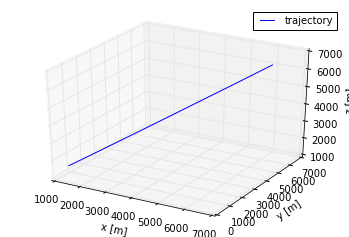

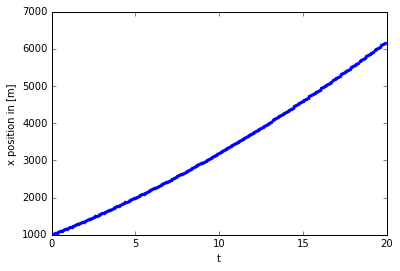

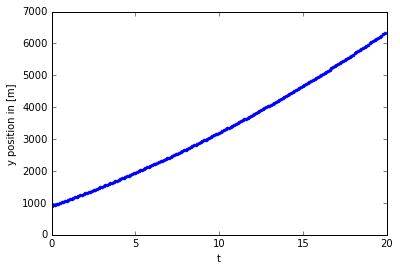

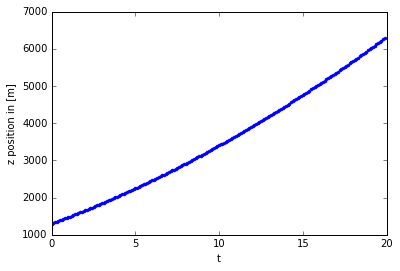

In [8]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mpl.rcParams['legend.fontsize'] = 10

ax = fig.gca(projection='3d')
ax.plot(x_state[0,:], x_state[3,:], x_state[6,:], label='trajectory')
ax.legend()

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

plt.show()

fig = plt.figure()
plt.plot(t,x_state[0,:],'b.')
plt.ylabel('x position in [m]')
plt.xlabel('t')
plt.show()

fig = plt.figure()
plt.plot(t,x_state[3,:],'b.')
plt.ylabel('y position in [m]')
plt.xlabel('t')
plt.show()

fig = plt.figure()
plt.plot(t,x_state[6,:],'b.')
plt.ylabel('z position in [m]')
plt.xlabel('t')
plt.show()

In [9]:
## extended Kalman filter functions ###########################################
def fnEKF_predict( F,A, m, P, Q):
    # fnKF_predict implements the extended Kalman Filter predict step.
    # F is the nonlinear dynamics function.
    # A is the Jacobian of the function F evaluated at m.
    # m is the mean, P is the covariance matrix.
    # process noise: Q matrix
    m_pred = np.dot(F,m);
    P_pred = np.add(np.dot(np.dot(A,P),np.transpose(A)),Q);
    # m_pred and P_pred are the predicted mean state vector and covariance
    # matrix at the current time step before seeing the measurement.
    return m_pred, P_pred

def fnEKF_update(m_minus, P_minus, y,H,M, R ):
    # m_minus,P_minus: state vector and covariance matrix
    # y is the measurement vector. H is the nonlinear measurement function and
    # M is its Jacobian. R is the measurement covariance matrix.
    innovation_mean = H;
    prediction_covariance = np.add(R ,np.dot(M,np.dot(P_minus,np.transpose(M))));
    KalmanGain = np.dot(np.dot(P_minus,np.transpose(M)),np.linalg.inv(prediction_covariance));
    # Calculate estimated mean state vector and its covariance matrix.
    m = m_minus + np.dot(KalmanGain , (y - innovation_mean));
    
    P = np.subtract(P_minus,np.dot(np.dot(KalmanGain,prediction_covariance),np.transpose(KalmanGain)));
    return m,P

In [10]:
## Filter the sensor data  ##
x_state_hat = np.zeros([9,len(t)],dtype=float)
x_state_hat[:,0] = m0;
P_hat = np.zeros([9,9,len(t)],dtype=float);
P_hat[:,:,0] = P0;
M = np.zeros([3,9],dtype=float);

# A = state sensitivity matrix 
Asmall=np.array([[0,1.0,0],[0,0,1.0],[0,0,0]],dtype=float); 
A = fn_Create_Concatenated_Block_Diag_Matrix(Asmall,dimensionality-1);

for index in range (1,x_state_hat.shape[1]-1):
    m_pred,P_pred = fnEKF_predict( stm3,A,x_state_hat[:,index-1], P_hat[:,:,index-1], Qd3);
    pos = np.array([m_pred[0],m_pred[3],m_pred[6]],dtype=float);
    Htilde = fnJacobianH(pos);  
    M[:,0] = Htilde[:,0]; M[:,3] =Htilde[:,1];M[:,6] =Htilde[:,2];
    x_state_hat[:,index],P_hat[:,:,index] = fnEKF_update(m_pred, P_pred, y_meas[:,index],fnH(pos),M, R );

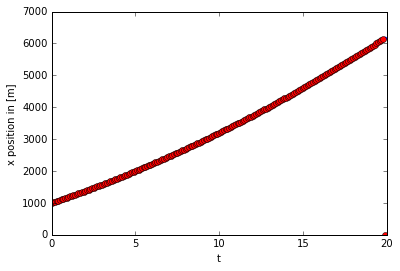

In [11]:
fig = plt.figure()
plt.plot(t,x_state[0,:],'b.')
plt.plot(t,x_state_hat[0,:],'ro')
plt.ylabel('x position in [m]')
plt.xlabel('t')
plt.show()

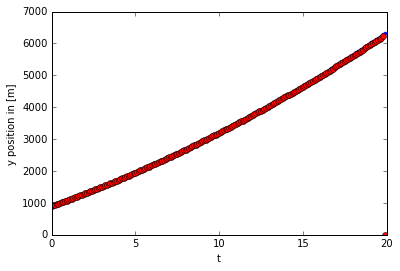

In [12]:
fig = plt.figure()
plt.plot(t,x_state[3,:],'b.')
plt.plot(t,x_state_hat[3,:],'ro')
plt.ylabel('y position in [m]')
plt.xlabel('t')
plt.show()

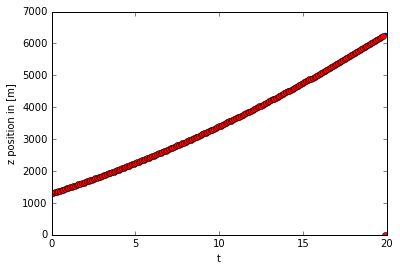

In [13]:
fig = plt.figure()
plt.plot(t,x_state[6,:],'b.')
plt.plot(t,x_state_hat[6,:],'ro')
plt.ylabel('z position in [m]')
plt.xlabel('t')
plt.show()

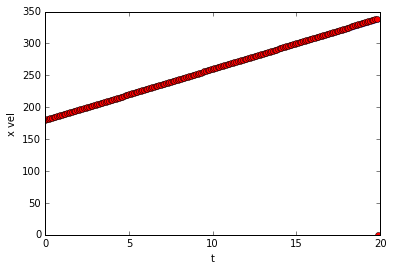

In [14]:
fig = plt.figure()
plt.plot(t,x_state[1,:],'b.')
plt.plot(t,x_state_hat[1,:],'ro')
plt.ylabel('x vel')
plt.xlabel('t')
plt.show()

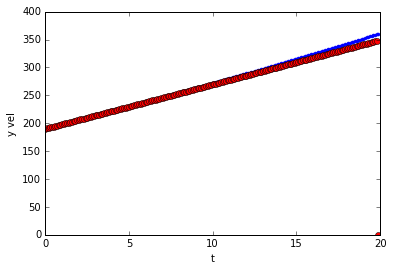

In [15]:
fig = plt.figure()
plt.plot(t,x_state[4,:],'b.')
plt.plot(t,x_state_hat[4,:],'ro')
plt.ylabel('y vel')
plt.xlabel('t')
plt.show()

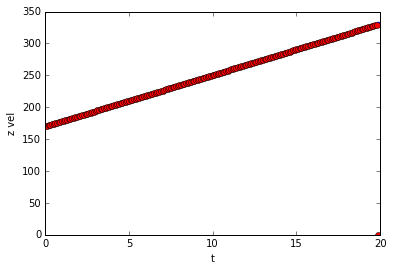

In [16]:
fig = plt.figure()
plt.plot(t,x_state[7,:],'b.')
plt.plot(t,x_state_hat[7,:],'ro')
plt.ylabel('z vel')
plt.xlabel('t')
plt.show()

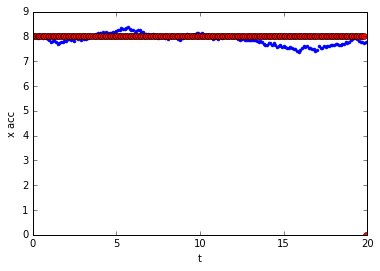

In [17]:
fig = plt.figure()
plt.plot(t,x_state[2,:],'b.')
plt.plot(t,x_state_hat[2,:],'ro')
plt.ylabel('x acc')
plt.xlabel('t')
plt.show()

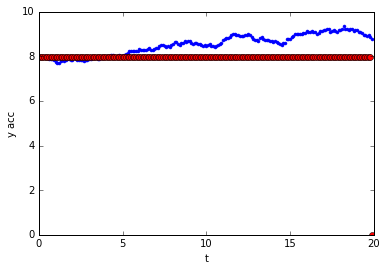

In [18]:
fig = plt.figure()
plt.plot(t,x_state[5,:],'b.')
plt.plot(t,x_state_hat[5,:],'ro')
plt.ylabel('y acc')
plt.xlabel('t')
plt.show()

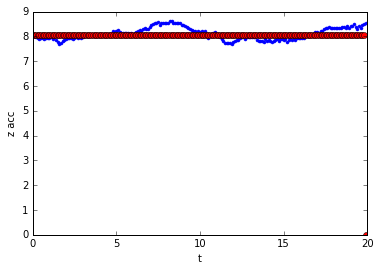

In [19]:
fig = plt.figure()
plt.plot(t,x_state[8,:],'b.')
plt.plot(t,x_state_hat[8,:],'ro')
plt.ylabel('z acc')
plt.xlabel('t')
plt.show()

In [20]:
## Compute the RMS Error ######################################################
epsilon = np.zeros_like(y_meas,dtype=float);
squared_error = np.zeros_like(t,dtype=float);
Rinv = np.linalg.inv(R);
for index in range (0,x_state_hat.shape[1]-1):
    pos = np.array([x_state_hat[0,index],x_state_hat[3,index],x_state_hat[6,index]],dtype=float);
    epsilon[:,index] = np.subtract(y_meas[:,index],fnH(pos));
    squared_error[index] = np.dot(np.dot(np.transpose(epsilon[:,index]),Rinv),epsilon[:,index]);
mse = np.sum(squared_error)/float(np.shape(epsilon)[0]*np.shape(squared_error)[0]);
rmse = math.sqrt(mse);
print rmse

7.66023476483
